In [6]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [51]:
adata_allcells = sc.read_h5ad("./adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering', 'SubclusteringV2'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'SubclusteringV2_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups

In [52]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['CoarseClustering'].isin(['T,NK cells']), :]
adata

View of AnnData object with n_obs × n_vars = 44669 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering', 'SubclusteringV2'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'SubclusteringV2_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

# Figure 4C,D and Associated Supplemental Figure pseudobulk log2(CPM+1) per granuloma (all TNK cells)

In [53]:
def extract_pseudobulk_log2CPM(adata, group_by_col='sample_id', subset=None):
    # subset function: "gate" on CD4+ or CD8+ T cells (similar to Flow cyto)
    if subset:
        if subset == "CD4+":
            adata = adata[adata[:, 'CD4'].X > 0, :]
        elif subset == "CD8A-":
            adata = adata[adata[:, 'CD8A'].X <= 0, :]
        elif subset == "CD8A+":
            adata = adata[adata[:, 'CD8A'].X > 0, :]
        elif subset == "CD4-":
            adata = adata[adata[:, 'CD4'].X <= 0, :]
    
    # convert to df using raw data if available
    if adata.raw:
        df = pd.DataFrame(adata.raw.X.toarray(), columns=adata.raw.var_names, index=adata.obs_names)
    else:
        df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names, index=adata.obs_names)
    
    df[group_by_col] = adata.obs[group_by_col].values
    df['Group'] = adata.obs['Group'].values

    # aggregate counts by sample and group
    aggregated_counts = df.groupby([group_by_col, 'Group']).sum().reset_index()
    
    # calculate log2(CPM+1)
    total_counts_per_sample = aggregated_counts.iloc[:, 2:].sum(axis=1).to_numpy()  # Skip the first two columns
    cpm = (aggregated_counts.iloc[:, 2:] / total_counts_per_sample[:, None]) * 1e6
    log2cpm = np.log2(cpm + 1)
    
    log2cpm[group_by_col] = aggregated_counts[group_by_col]
    log2cpm['Group'] = aggregated_counts['Group']
    
    return log2cpm

def filter_genes_log2cpm(log2cpm_df, genes_list, group_by_col):
    # keep specified genes, along with 'Group' and group_by_col
    filtered_log2cpm = log2cpm_df[genes_list + ['Group', group_by_col]]
    return filtered_log2cpm



In [ ]:
genes = [
"GZMA", "GZMB", "GZMH","GZMK", "PRF1","GNLY",
    #TFs
    "BATF3", "TCF7", "LEF1", "EOMES", "TBX21", "ZEB2", "KLF3", "GATA3", "FOXP3", "ZNF683",
"SATB1", "IRF2BP2", "FOSL2", "SMAD7", "IRF2", "BCL3",
# chemokine cytokine 
"CX3CR1", "CXCR3", "CXCR4", "CXCR6", "CCR5", "CCR6", "IL7R", "IL26", "TGFB1", "TGFBR2",
# immunomodulator
"HAVCR2", "TOX2", "CD160", "LAIR2", "CD2", "CD28", "ICOS", "CD5", "CD6", "CD40LG",
"CLEC12A", "KLRG1", "KLRB1", "NKG7", "CD274",
# ISG
"NFKBIZ", "ISG15", "MX1", "IFI27",
# other 
"ORAI1", "FURIN"
              ]

genes=["CD4", "CD8A", "CD8B","RORA", "RORC", "HIF1A", "BHLHE40", "IFNG", "TNF", "IL10", "IL21", "ENTPD1",
              "CTLA4", "LAG3", "CD38", "CD244", "TOX", "TIGIT", "PDCD1"]

In [63]:
genes = [
"GZMA", "GZMB", "GZMH","GZMK", "PRF1","GNLY",
    #TFs
    "BATF3", "TCF7", "LEF1", "EOMES", "TBX21", "ZEB2", "KLF3", "GATA3", "FOXP3", "ZNF683",
"SATB1", "IRF2BP2", "FOSL2", "SMAD7", "IRF2", "BCL3",
# chemokine cytokine 
"CX3CR1", "CXCR3", "CXCR4", "CXCR6", "CCR5", "CCR6", "IL7R", "IL26", "TGFB1", "TGFBR2",
# immunomodulator
"HAVCR2", "TOX2", "CD160", "LAIR2", "CD2", "CD28", "ICOS", "CD5", "CD6", "CD40LG",
"CLEC12A", "KLRG1", "KLRB1", "NKG7", "CD274",
# ISG
"NFKBIZ", "ISG15", "MX1", "IFI27",
# other 
"ORAI1", "FURIN"
              ]
# extract pseudobulk log2CPM values
all_log2cpm_values = extract_pseudobulk_log2CPM(adata, group_by_col='array number')
# Filter log2CPM values for the genes of interest
filtered_log2cpm_values = filter_genes_log2cpm(all_log2cpm_values, genes, group_by_col='array number')
filtered_log2cpm_values


,GZMA,GZMB,GZMH,GZMK,PRF1,GNLY,BATF3,TCF7,LEF1,EOMES,...,NKG7,CD274,NFKBIZ,ISG15,MX1,IFI27,ORAI1,FURIN,Group,array number
0,8.039171,11.231329,10.054142,9.432199,8.264882,10.422917,2.481765,7.999096,5.550225,7.685327,...,9.113526,3.521282,7.467667,5.779727,4.822549,6.461566,8.165243,6.295023,IgG,12518_Array2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Naïve,12518_Array2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,antiCD4,12518_Array2
3,8.864611,11.927914,10.762940,9.831273,8.769252,11.077361,3.120789,8.771102,6.542933,8.150609,...,9.156940,2.124131,7.976337,7.250896,6.213483,6.909999,8.214549,7.253546,IgG,12518_Array3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Naïve,12518_Array3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Naïve,14218_Array11
95,6.706870,12.037286,10.769024,8.333206,9.109551,11.011740,3.641100,7.889702,4.865543,7.760852,...,9.618129,3.062105,8.424882,7.064713,5.616368,6.791041,8.480985,8.034862,antiCD4,14218_Array11
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IgG,14218_Array12
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Naïve,14218_Array12


In [64]:
print("Unique groups in the pseudobulk matrix:")
print(filtered_log2cpm_values['Group'].unique())

Unique groups in the pseudobulk matrix:
['IgG', 'Naïve', 'antiCD4']
Categories (3, object): ['IgG', 'Naïve', 'antiCD4']


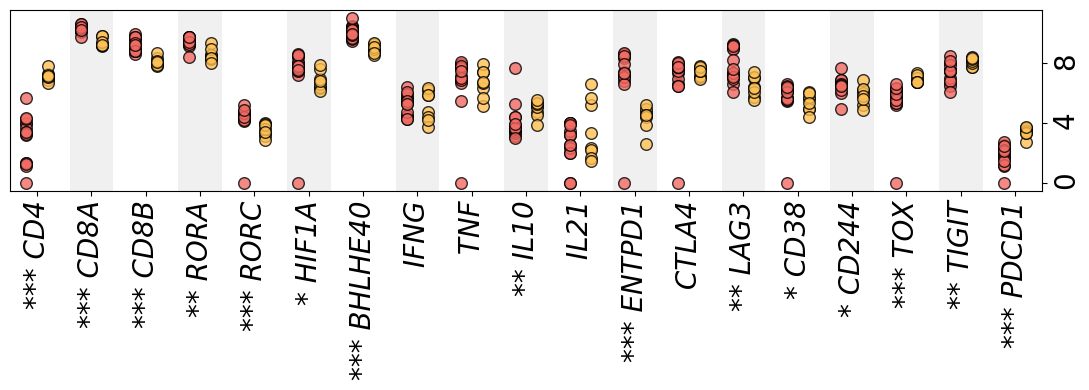

P-values:
CD4: 0.000108
CD8A: 0.000181
CD8B: 0.000140
RORA: 0.001249
RORC: 0.000789
HIF1A: 0.011821
BHLHE40: 0.000108
IFNG: 0.897279
TNF: 0.175244
IL10: 0.005509
IL21: 0.651378
ENTPD1: 0.000789
CTLA4: 0.948533
LAG3: 0.004509
CD38: 0.023868
CD244: 0.020137
TOX: 0.000108
TIGIT: 0.004509
PDCD1: 0.000108


In [62]:
from scipy.stats import ranksums
import matplotlib.patches as patches

def plot_strip_log2cpm(log2cpm_df, genes_list, group_col, save=None):
    fig, ax = plt.subplots(figsize=(11, 4))
    
    dodge = 0.2  
    stars = []  
    p_values = {}
    
    for idx, gene in enumerate(genes_list):
        anticd4_vals = log2cpm_df.loc[log2cpm_df[group_col] == "antiCD4", gene].dropna().values
        igg_vals = log2cpm_df.loc[log2cpm_df[group_col] == "IgG", gene].dropna().values
        
        ax.scatter([idx - dodge]*len(anticd4_vals), anticd4_vals, color=reinfection_palette["antiCD4"], s=70, edgecolors='black', alpha=0.8)
        ax.scatter([idx + dodge]*len(igg_vals), igg_vals, color=reinfection_palette["IgG"], s=70, edgecolors='black', alpha=0.8)
        
        # Wilcoxon rank-sum test
        _, p_value = ranksums(anticd4_vals, igg_vals)
        p_values[gene] = p_value
        
        # define significance levels/what will be annotated on fig
        if p_value < 0.001:
            stars.append("***")
        elif p_value < 0.01:
            stars.append("**")
        elif p_value < 0.05:
            stars.append("*")
        else:
            stars.append("")
    
    for idx in range(1, len(genes_list), 2):
        ax.add_patch(patches.Rectangle((idx-0.4, ax.get_ylim()[0]), 0.8, ax.get_ylim()[1] - ax.get_ylim()[0], facecolor="#f0f0f0", edgecolor='none', zorder=-20))
    
    ax.grid(False)  
    ax.set_xlim(-0.5, len(genes_list)-0.5)  
    ax.set_xticks(range(len(genes_list)))
    ax.set_xticklabels([f"{star} {gene}" for star, gene in zip(stars, genes_list)], rotation=90, fontstyle='italic')
    plt.xticks(fontsize=20)
    
    y_min, y_max = ax.get_ylim()
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax.yaxis.tick_right()
    ax.yaxis.set_tick_params(rotation=90)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    
    if save:
        plt.savefig(save, dpi=1000, bbox_inches='tight', transparent=True)
    plt.show()
    
    # Print p-values
    print("P-values:")
    for gene, p_value in p_values.items():
        print(f"{gene}: {p_value:.6f}")
    
    return p_values
# plot antCD4 logCPM (NO "gating applied)
p_values = plot_strip_log2cpm(filtered_log2cpm_values, genes, 'Group', save=".Figure4/aCD4_IgG_CPM_StripPlot_genes_for_Publication.png")

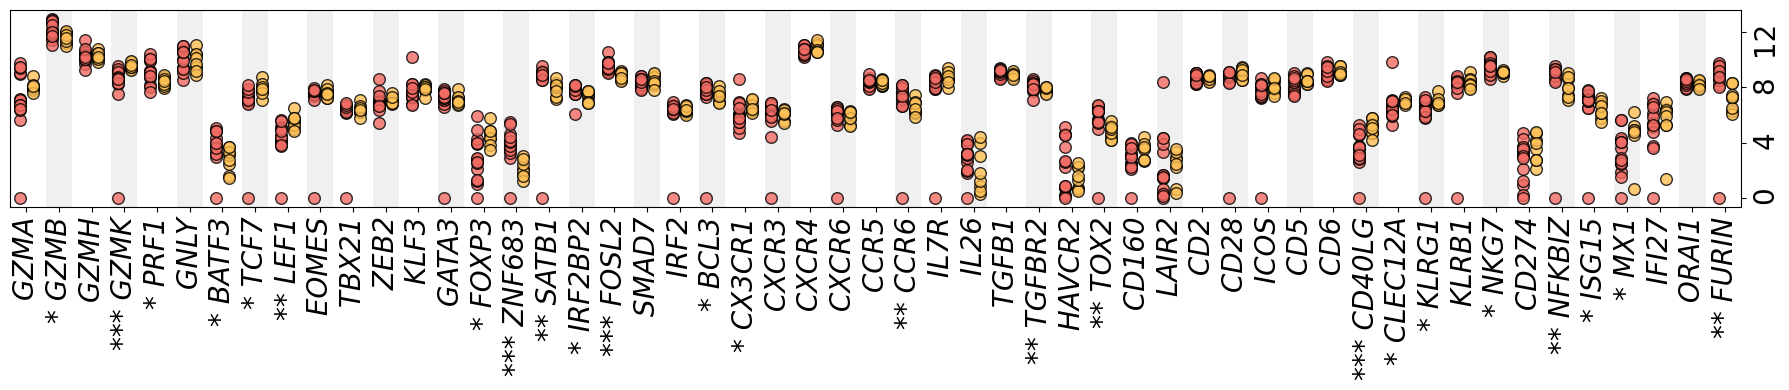

P-values:
GZMA: 0.196706
GZMB: 0.038867
GZMH: 0.948533
GZMK: 0.000491
PRF1: 0.020137
GNLY: 0.477675
BATF3: 0.020137
TCF7: 0.014171
LEF1: 0.002415
EOMES: 0.897279
TBX21: 0.746886
ZEB2: 0.137638
KLF3: 0.121335
GATA3: 0.272490
FOXP3: 0.020137
ZNF683: 0.000995
SATB1: 0.001249
IRF2BP2: 0.014171
FOSL2: 0.000491
SMAD7: 0.518605
IRF2: 0.477675
BCL3: 0.020137
CX3CR1: 0.020137
CXCR3: 0.651378
CXCR4: 0.137638
CXCR6: 0.175244
CCR5: 0.605577
CCR6: 0.009823
IL7R: 0.196706
IL26: 0.196706
TGFB1: 0.245278
TGFBR2: 0.009823
HAVCR2: 0.366157
TOX2: 0.002985
CD160: 0.155580
LAIR2: 0.561276
CD2: 0.651378
CD28: 0.245278
ICOS: 0.477675
CD5: 0.061215
CD6: 0.175244
CD40LG: 0.000995
CLEC12A: 0.011821
KLRG1: 0.033160
KLRB1: 0.796253
NKG7: 0.023868
CD274: 0.175244
NFKBIZ: 0.004509
ISG15: 0.014171
MX1: 0.028186
IFI27: 0.401387
ORAI1: 0.070701
FURIN: 0.001946


In [67]:
def plot_strip_log2cpm(log2cpm_df, genes_list, group_col, save=None):
    fig, ax = plt.subplots(figsize=(18, 4))
    
    dodge = 0.2  
    stars = []  
    p_values = {}
    
    for idx, gene in enumerate(genes_list):
        anticd4_vals = log2cpm_df.loc[log2cpm_df[group_col] == "antiCD4", gene].dropna().values
        igg_vals = log2cpm_df.loc[log2cpm_df[group_col] == "IgG", gene].dropna().values
        
        ax.scatter([idx - dodge]*len(anticd4_vals), anticd4_vals, color=reinfection_palette["antiCD4"], s=70, edgecolors='black', alpha=0.8)
        ax.scatter([idx + dodge]*len(igg_vals), igg_vals, color=reinfection_palette["IgG"], s=70, edgecolors='black', alpha=0.8)
        
        # Wilcoxon rank-sum test
        _, p_value = ranksums(anticd4_vals, igg_vals)
        p_values[gene] = p_value
        
        # define significance levels/what will be annotated on fig
        if p_value < 0.001:
            stars.append("***")
        elif p_value < 0.01:
            stars.append("**")
        elif p_value < 0.05:
            stars.append("*")
        else:
            stars.append("")
    
    for idx in range(1, len(genes_list), 2):
        ax.add_patch(patches.Rectangle((idx-0.4, ax.get_ylim()[0]), 0.8, ax.get_ylim()[1] - ax.get_ylim()[0], facecolor="#f0f0f0", edgecolor='none', zorder=-20))
    
    ax.grid(False)  
    ax.set_xlim(-0.5, len(genes_list)-0.5)  
    ax.set_xticks(range(len(genes_list)))
    ax.set_xticklabels([f"{star} {gene}" for star, gene in zip(stars, genes_list)], rotation=90, fontstyle='italic')
    plt.xticks(fontsize=20)
    
    y_min, y_max = ax.get_ylim()
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax.yaxis.tick_right()
    ax.yaxis.set_tick_params(rotation=90)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    
    if save:
        plt.savefig(save, dpi=1000, bbox_inches='tight', transparent=True)
    plt.show()
    
    # Print p-values
    print("P-values:")
    for gene, p_value in p_values.items():
        print(f"{gene}: {p_value:.6f}")
    
    return p_values

p_values = plot_strip_log2cpm(filtered_log2cpm_values, genes, 'Group', save="./Figure4/Supplemental_aCD4_IgG_CPM_StripPlot_genes_for_Publication.png")

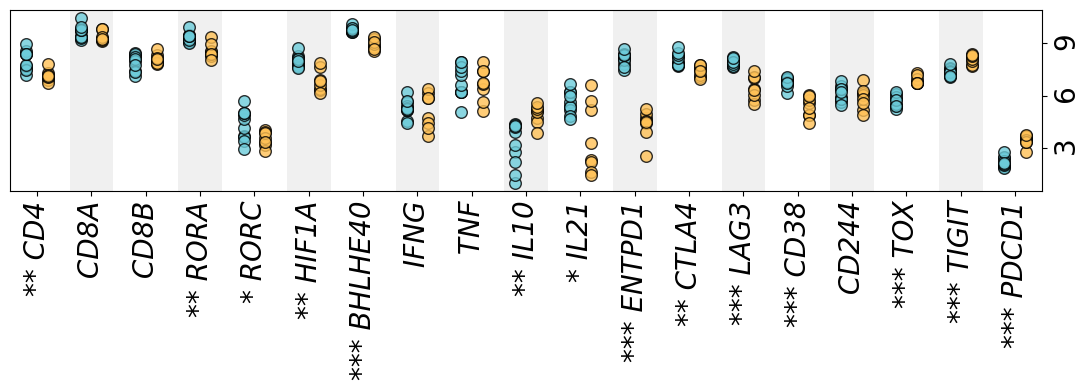

P-values:
CD4: 0.003366
CD8A: 0.091374
CD8B: 0.593955
RORA: 0.001872
RORC: 0.040993
HIF1A: 0.001872
BHLHE40: 0.000379
IFNG: 0.929199
TNF: 0.789810
IL10: 0.001872
IL21: 0.040993
ENTPD1: 0.000379
CTLA4: 0.001011
LAG3: 0.000379
CD38: 0.000379
CD244: 0.328383
TOX: 0.000379
TIGIT: 0.000734
PDCD1: 0.000379


In [61]:
def plot_strip_log2cpm(log2cpm_df, genes_list, group_col, save=None):
    fig, ax = plt.subplots(figsize=(11, 4))
    
    dodge = 0.2  
    stars = []  
    p_values = {}
    
    for idx, gene in enumerate(genes_list):
        anticd4_vals = log2cpm_df.loc[log2cpm_df[group_col] == "Naïve", gene].dropna().values
        igg_vals = log2cpm_df.loc[log2cpm_df[group_col] == "IgG", gene].dropna().values
        
        ax.scatter([idx - dodge]*len(anticd4_vals), anticd4_vals, color=reinfection_palette["Naïve"], s=70, edgecolors='black', alpha=0.8)
        ax.scatter([idx + dodge]*len(igg_vals), igg_vals, color=reinfection_palette["IgG"], s=70, edgecolors='black', alpha=0.8)
        
        # Wilcoxon rank-sum test
        _, p_value = ranksums(anticd4_vals, igg_vals)
        p_values[gene] = p_value
        
        # define significance levels/what will be annotated on fig
        if p_value < 0.001:
            stars.append("***")
        elif p_value < 0.01:
            stars.append("**")
        elif p_value < 0.05:
            stars.append("*")
        else:
            stars.append("")
    
    for idx in range(1, len(genes_list), 2):
        ax.add_patch(patches.Rectangle((idx-0.4, ax.get_ylim()[0]), 0.8, ax.get_ylim()[1] - ax.get_ylim()[0], facecolor="#f0f0f0", edgecolor='none', zorder=-20))
    
    ax.grid(False)  
    ax.set_xlim(-0.5, len(genes_list)-0.5)  
    ax.set_xticks(range(len(genes_list)))
    ax.set_xticklabels([f"{star} {gene}" for star, gene in zip(stars, genes_list)], rotation=90, fontstyle='italic')
    plt.xticks(fontsize=20)
    
    y_min, y_max = ax.get_ylim()
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax.yaxis.tick_right()
    ax.yaxis.set_tick_params(rotation=90)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    
    if save:
        plt.savefig(save, dpi=1000, bbox_inches='tight', transparent=True)
    plt.show()
    
    # Print p-values
    print("P-values:")
    for gene, p_value in p_values.items():
        print(f"{gene}: {p_value:.6f}")
    
    return p_values

p_values = plot_strip_log2cpm(filtered_log2cpm_values, genes, 'Group', save="./Figure4/Naïve_IgG_CPM_StripPlot_genes_for_Publication.png")

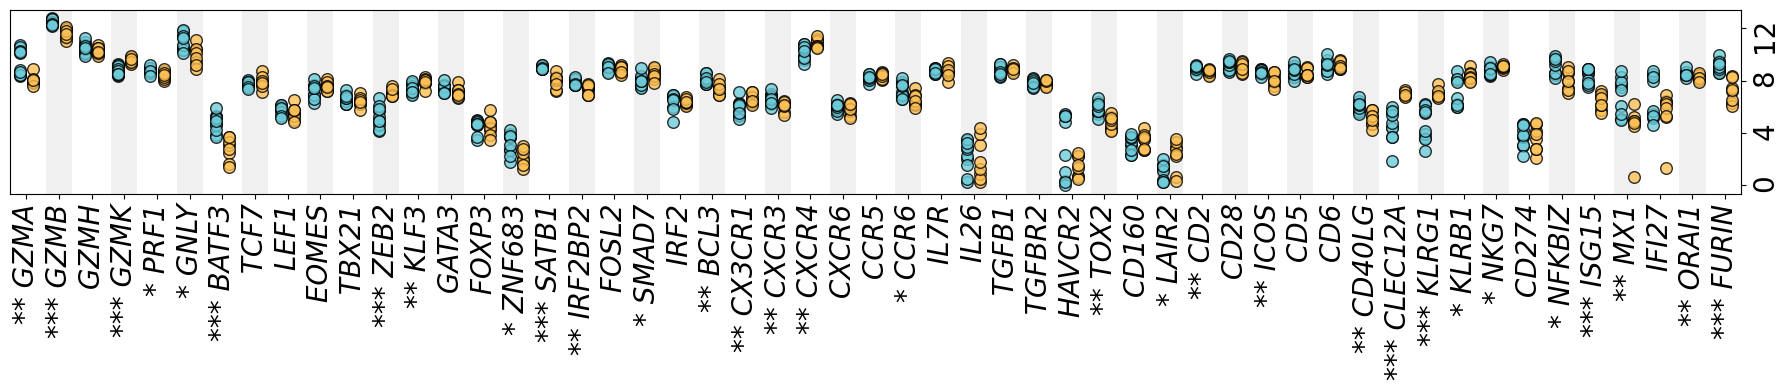

P-values:
GZMA: 0.001872
GZMB: 0.000379
GZMH: 0.286321
GZMK: 0.000530
PRF1: 0.026330
GNLY: 0.012851
BATF3: 0.000734
TCF7: 0.423901
LEF1: 0.091374
EOMES: 0.109745
TBX21: 0.423901
ZEB2: 0.000379
KLF3: 0.005880
GATA3: 0.091374
FOXP3: 0.656853
ZNF683: 0.012851
SATB1: 0.000379
IRF2BP2: 0.004465
FOSL2: 0.248058
SMAD7: 0.032969
IRF2: 0.286321
BCL3: 0.007686
CX3CR1: 0.007686
CXCR3: 0.007686
CXCR4: 0.005880
CXCR6: 0.858955
CCR5: 0.286321
CCR6: 0.012851
IL7R: 0.593955
IL26: 0.722283
TGFB1: 0.477197
TGFBR2: 0.423901
HAVCR2: 0.374259
TOX2: 0.001381
CD160: 0.656853
LAIR2: 0.026330
CD2: 0.007686
CD28: 0.423901
ICOS: 0.009974
CD5: 0.477197
CD6: 0.533964
CD40LG: 0.002520
CLEC12A: 0.000379
KLRG1: 0.000379
KLRB1: 0.020879
NKG7: 0.032969
CD274: 0.789810
NFKBIZ: 0.026330
ISG15: 0.000379
MX1: 0.002520
IFI27: 0.328383
ORAI1: 0.009974
FURIN: 0.000379


In [69]:
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_strip_log2cpm(log2cpm_df, genes_list, group_col, save=None):
    fig, ax = plt.subplots(figsize=(18, 4))
    
    dodge = 0.2  
    stars = []  
    p_values = {}
    
    for idx, gene in enumerate(genes_list):
        anticd4_vals = log2cpm_df.loc[log2cpm_df[group_col] == "Naïve", gene].dropna().values
        igg_vals = log2cpm_df.loc[log2cpm_df[group_col] == "IgG", gene].dropna().values
        
        ax.scatter([idx - dodge]*len(anticd4_vals), anticd4_vals, color=reinfection_palette["Naïve"], s=70, edgecolors='black', alpha=0.8)
        ax.scatter([idx + dodge]*len(igg_vals), igg_vals, color=reinfection_palette["IgG"], s=70, edgecolors='black', alpha=0.8)
        
        # Wilcoxon rank-sum test
        _, p_value = ranksums(anticd4_vals, igg_vals)
        p_values[gene] = p_value
        
        # define significance levels/what will be annotated on fig
        if p_value < 0.001:
            stars.append("***")
        elif p_value < 0.01:
            stars.append("**")
        elif p_value < 0.05:
            stars.append("*")
        else:
            stars.append("")
    
    for idx in range(1, len(genes_list), 2):
        ax.add_patch(patches.Rectangle((idx-0.4, ax.get_ylim()[0]), 0.8, ax.get_ylim()[1] - ax.get_ylim()[0], facecolor="#f0f0f0", edgecolor='none', zorder=-20))
    
    ax.grid(False)  
    ax.set_xlim(-0.5, len(genes_list)-0.5)  
    ax.set_xticks(range(len(genes_list)))
    ax.set_xticklabels([f"{star} {gene}" for star, gene in zip(stars, genes_list)], rotation=90, fontstyle='italic')
    plt.xticks(fontsize=20)
    
    y_min, y_max = ax.get_ylim()
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax.yaxis.tick_right()
    ax.yaxis.set_tick_params(rotation=90)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    
    if save:
        plt.savefig(save, dpi=1000, bbox_inches='tight', transparent=True)
    plt.show()
    
    # Print p-values
    print("P-values:")
    for gene, p_value in p_values.items():
        print(f"{gene}: {p_value:.6f}")
    
    return p_values

p_values = plot_strip_log2cpm(filtered_log2cpm_values, genes, 'Group', save="./Figure4/Supplemental_Naïve_IgG_CPM_StripPlot_genes_for_Publication.png")

# T,NK cell Associated Supplemental Figure (progeny analyses)

In [42]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['CoarseClustering'].isin(['T,NK cells']), :]
adata = adata[adata.obs['Group'].isin(["Naïve","IgG"]), :]
adata

View of AnnData object with n_obs × n_vars = 22087 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering', 'SubclusteringV2'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'SubclusteringV2_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [43]:
adata_raw=adata

In [44]:
from scipy.stats import ttest_ind
import decoupler as dc
import liana as li
import decoupler as dc
import omnipath as op
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
sample_key = 'DGE_name'
groupby = 'SubclusteringV2'
condition_key = 'Group'

if 'counts' not in adata_raw.layers.keys():
    adata_raw.layers['counts'] = adata_raw.X.copy()

pdata = dc.get_pseudobulk(
    adata_raw,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)

print(pdata)

pdata.X = np.round(pdata.X).astype(int)

dea_results = {}
quiet = True

for cell_group in pdata.obs[groupby].unique():
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    
    genes = dc.filter_by_expr(
        ctdata,
        group=condition_key,
        min_count=5,
        min_total_count=10
    )
    
    ctdata = ctdata[:, genes].copy()
    
    ctdata.X = np.round(ctdata.X).astype(int)
    
    #run DESeq2
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'Naïve'],
        refit_cooks=True,
        quiet=quiet
    )
    
    dds.deseq2()
    
    # compute statistics for contrast between IgG and Naïve OR IgG vs antiCD4 (need to update group name each type you run progeny)
    stat_res = DeseqStats(dds, contrast=[condition_key, 'IgG', 'Naïve'], quiet=quiet)
    stat_res.quiet = quiet
    
    stat_res.summary()
    stat_res.lfc_shrink(coeff='Group_IgG_vs_Naïve')
    
    dea_results[cell_group] = stat_res.results_df

for key, df in dea_results.items():
    print(f"Results for {key}:\n", df.head())
    break

# concatenate across cell types
dea_df = pd.concat(dea_results, names=[groupby]).reset_index()

dea_df = dea_df.rename(columns={groupby: 'cell_type'}).set_index('level_1')

print(dea_df.head())

AnnData object with n_obs × n_vars = 173 × 24878
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering', 'SubclusteringV2', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells', 'Blacklist_Genes'
    layers: 'psbulk_props'


Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AAAS          6.194173       -0.247044  0.418536 -0.590257  5.550183e-01   
AACS         15.718837       -0.174445  0.268710 -0.649192  5.162145e-01   
AAED1        20.061582       -0.034254  0.300999 -0.113802  9.093948e-01   
AAGAB         5.731582       -0.617306  0.423008 -1.459325  1.444756e-01   
AAK1         14.719816        0.469394  0.248707  1.887339  5.911479e-02   
...                ...             ...       ...       ...           ...   
ZYX          22.228122        0.932489  0.359658  2.592711  9.522267e-03   
ZZEF1        27.544065        0.373633  0.250027  1.494375  1.350777e-01   
ZZZ3         24.584673        0.165025  0.240722  0.685542  4.930022e-01   
rna76576   2203.538389        1.776651  0.301984  5.883258  4.022674e-09   
rna76578  21257.456741        0.404248  0.131174  3.081780  2.057667e-03   

              padj  
AAAS     

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS          4.937465        0.696398  1.019812  0.682869  0.494690       NaN
AACS         26.828330        0.954042  0.607510  1.570413  0.116319  0.701789
AAED1        15.662244       -0.051620  0.706852 -0.073029  0.941783  0.987761
AAGAB        12.928938       -0.181254  0.768747 -0.235778  0.813605  0.959561
AAK1         14.890640        0.500327  0.679793  0.735998  0.461732  0.853214
...                ...             ...       ...       ...       ...       ...
ZYX          14.523285        0.153787  0.783679  0.196238  0.844424  0.969157
ZZEF1        32.400965        0.210462  0.548164  0.383941  0.701022  0.924008
ZZZ3         36.723404        1.003822  0.442599  2.268019  0.023328  0.463978
rna76576    970.028018        0.668022  0.926794  0.720789  0.471039  0.855212
rna76578  21095.132964        0.059613  0.342723  0.173941  0.861912  0.96

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS          9.875466       -0.139962  0.305144 -0.458675  0.646467  0.876835
AACS         30.617581        0.201617  0.230869  0.873295  0.382502  0.728013
AAED1        41.760813        0.033184  0.187512  0.176971  0.859531  0.959236
AAGAB        16.700651       -0.007109  0.238473 -0.029812  0.976217  0.994862
AAK1         32.343044        0.478358  0.247685  1.931316  0.053444  0.302439
...                ...             ...       ...       ...       ...       ...
ZZZ3         79.858061        0.209039  0.149244  1.400649  0.161319  0.505387
rna76576   4936.026719        1.223693  0.326594  3.746834  0.000179  0.010356
rna76577      6.410653        1.326358  1.149515  1.153842  0.248565  0.614331
rna76578  54785.006315        0.037280  0.154729  0.240939  0.809602  0.941611
rna76594      5.414579        0.291988  0.558799  0.522528  0.601303  0.85

/opt/anaconda3/lib/python3.11/site-packages/pydeseq2/utils.py:1249: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Shrunk log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS          9.875466       -0.033087  0.173421 -0.458675  0.646467  0.876835
AACS         30.617581        0.075602  0.169483  0.873295  0.382502  0.728013
AAED1        41.760813        0.015109  0.140652  0.176971  0.859531  0.959236
AAGAB        16.700651       -0.002529  0.156396 -0.029812  0.976217  0.994862
AAK1         32.343044        0.221777  0.241894  1.931316  0.053444  0.302439
...                ...             ...       ...       ...       ...       ...
ZZZ3         79.858061        0.131525  0.136070  1.400649  0.161319  0.505387
rna76576   4936.026719        1.016529  0.340275  3.746834  0.000179  0.010356
rna76577      6.410653        0.028190  0.275287  1.153842  0.248565  0.614331
rna76578  54785.006315       -0.028416  0.130729  0.240939  0.809602  0.941611
rna76594      5.414579        0.024631  0.205451  0.522528  0.60130

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS          7.366109       -0.474469  0.583266 -0.813469  0.415949  0.789148
AACS         25.035073        0.436355  0.309321  1.410686  0.158337  0.579571
AAED1        20.653152        0.533058  0.287863  1.851777  0.064058  0.419617
AAGAB        11.902029        0.458704  0.386518  1.186759  0.235323  0.657229
AAK1         15.579303        0.568644  0.333912  1.702976  0.088573  0.469723
...                ...             ...       ...       ...       ...       ...
ZYX          19.897304        0.238835  0.411281  0.580710  0.561436  0.865280
ZZEF1        38.604707        0.604150  0.242409  2.492281  0.012693  0.186177
ZZZ3         34.422337        0.142587  0.280561  0.508220  0.611299  0.886449
rna76576   1482.579503        1.118173  0.430104  2.599776  0.009328  0.157166
rna76578  22268.129441        0.311254  0.188419  1.651929  0.098549  0.48

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS          7.595906       -0.013752  0.350700 -0.039214  0.968720  0.990854
AACS         17.767798        0.544070  0.229856  2.367001  0.017933  0.162552
AAED1        25.206422        0.388834  0.221067  1.758895  0.078595  0.355162
AAGAB         8.393245        0.194939  0.300410  0.648909  0.516397  0.809504
AAK1         17.606991        0.492418  0.252307  1.951664  0.050978  0.288166
...                ...             ...       ...       ...       ...       ...
ZYX          16.230482        0.892316  0.292630  3.049297  0.002294  0.046411
ZZEF1        41.103570        0.161230  0.239987  0.671828  0.501693  0.800870
ZZZ3         38.274583       -0.031588  0.225253 -0.140234  0.888475  0.965154
rna76576   2303.680597        1.196368  0.331741  3.606333  0.000311  0.012332
rna76578  30475.956770       -0.021259  0.187413 -0.113432  0.909688  0.97

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS         2.644616        0.500506  0.818324  0.611624  0.540787  0.992232
AACS         4.569474        0.242665  0.681095  0.356286  0.721626  0.996922
AAED1        5.199253        0.126198  0.552736  0.228316  0.819401  0.996922
AAK1         3.742914        0.163264  0.690297  0.236513  0.813035  0.996922
AAMP         4.119913       -0.552319  0.630382 -0.876165  0.380940  0.992232
...               ...             ...       ...       ...       ...       ...
ZYX          4.054259        0.761058  0.604747  1.258474  0.208221  0.992232
ZZEF1        9.321181        0.599041  0.474326  1.262931  0.206614  0.992232
ZZZ3         8.187867        0.174771  0.450494  0.387955  0.698049  0.996922
rna76576   450.228220        1.025987  0.765519  1.340250  0.180164  0.992232
rna76578  6898.612852        0.309459  0.273687  1.130705  0.258179  0.992232

[5999 

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS          8.442978       -0.089345  0.358872 -0.248961  0.803391  0.964854
AACS         27.291321        0.082827  0.250581  0.330542  0.740990  0.950267
AAED1        23.226347       -0.030299  0.242145 -0.125126  0.900424  0.983980
AAGAB        10.707697        0.033564  0.334112  0.100457  0.919981  0.988948
AAK1         16.980693       -0.028386  0.250847 -0.113160  0.909903  0.986342
...                ...             ...       ...       ...       ...       ...
ZZZ3         42.890877       -0.128209  0.200504 -0.639433  0.522542  0.882345
rna76576   3162.458368        1.404955  0.331783  4.234556  0.000023  0.004860
rna76577      6.682439        1.641636  1.326235  1.237817  0.215784  0.673173
rna76578  36453.625668        0.122049  0.142770  0.854865  0.392626  0.811424
rna76594      5.822710        0.553954  0.563507  0.983047  0.325584  0.76

/opt/anaconda3/lib/python3.11/site-packages/pydeseq2/utils.py:1249: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Shrunk log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS          8.442978       -0.012457  0.157681 -0.248961  0.803391  0.964854
AACS         27.291321        0.020709  0.147489  0.330542  0.740990  0.950267
AAED1        23.226347       -0.008107  0.142966 -0.125126  0.900424  0.983980
AAGAB        10.707697        0.005160  0.156216  0.100457  0.919981  0.988948
AAK1         16.980693       -0.007029  0.143687 -0.113160  0.909903  0.986342
...                ...             ...       ...       ...       ...       ...
ZZZ3         42.890877       -0.044734  0.138297 -0.639433  0.522542  0.882345
rna76576   3162.458368        1.210343  0.341340  4.234556  0.000023  0.004860
rna76577      6.682439        0.018931  0.244048  1.237817  0.215784  0.673173
rna76578  36453.625668        0.003432  0.115015  0.854865  0.392626  0.811424
rna76594      5.822710        0.033365  0.184613  0.983047  0.32558

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS         11.128848       -0.111880  0.318408 -0.351373  0.725309  0.896787
AACS         38.655859        0.142234  0.212056  0.670740  0.502386  0.777941
AAED1        17.467256        0.123016  0.273162  0.450340  0.652466  0.864877
AAGAB        13.081727        0.399199  0.356797  1.118842  0.263208  0.586297
AAK1         19.104814        0.396557  0.266916  1.485699  0.137359  0.431333
...                ...             ...       ...       ...       ...       ...
ZYX          25.925268        0.371733  0.311353  1.193927  0.232507  0.552555
ZZEF1        40.940908        0.864060  0.291009  2.969183  0.002986  0.043624
ZZZ3         42.359914        0.367836  0.277535  1.325370  0.185048  0.500087
rna76576   1761.478200        1.354271  0.571739  2.368687  0.017851  0.135794
rna76578  25047.878452        0.344588  0.195576  1.761909  0.078085  0.31

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAAS          5.058908       -0.731707  0.548699 -1.333530  0.182358       NaN
AACS         10.781249        0.572166  0.361336  1.583473  0.113314  0.535509
AAED1         9.953585        0.510976  0.356754  1.432290  0.152061  0.598162
AAGAB         4.485594       -0.840230  0.616677 -1.362511  0.173037       NaN
AAK1          7.556584        0.699921  0.382354  1.830560  0.067166       NaN
...                ...             ...       ...       ...       ...       ...
ZYX           8.538575        0.274401  0.435717  0.629770  0.528845       NaN
ZZEF1        15.496802       -0.072484  0.425057 -0.170528  0.864595  0.968540
ZZZ3         21.023217        0.799101  0.244345  3.270375  0.001074  0.061180
rna76576   1081.372658        1.803192  0.477409  3.777037  0.000159  0.016086
rna76578  13584.927312        0.618632  0.218379  2.832839  0.004614  0.13

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group IgG vs Naïve
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AACS         6.305771        0.162451  0.391147  0.415320  0.677907  0.968546
AAED1        7.749720        0.295624  0.370157  0.798646  0.424496  0.912648
AAK1         5.410198        0.522733  0.466243  1.121160  0.262220  0.868754
AAMP         7.652114        0.434943  0.427544  1.017306  0.309008  0.879142
AARS         8.370937        0.611610  0.385602  1.586119  0.112712  0.739639
...               ...             ...       ...       ...       ...       ...
ZYX          7.304022        0.732151  0.388518  1.884473  0.059501  0.606932
ZZEF1       10.799891       -0.233833  0.432600 -0.540531  0.588831  0.955488
ZZZ3        11.047705       -0.067099  0.374451 -0.179192  0.857787  0.981710
rna76576   540.444286        1.209736  0.474929  2.547191  0.010859  0.321878
rna76578  7384.940472        0.065545  0.163389  0.401159  0.688303  0.968655

[5604 

In [45]:
def progeny_pathway_analysis(dea_df, condition_key='Group', cell_type_col='cell_type'):
    progeny_results = {}
    
    progeny_model = dc.get_progeny()
    
    for cell_type in dea_df[cell_type_col].unique():
        ct_data = dea_df[dea_df[cell_type_col] == cell_type]
        
        genes = ct_data.index.values  
        scores = ct_data['log2FoldChange'].values  
        
        df = pd.DataFrame({'genes': genes, 'scores': scores}).set_index('genes')
        
        mlm_results = dc.run_mlm(
            mat=df.T,
            net=progeny_model,
            source='source',
            target='target',
            weight='weight',
            verbose=True
        )

        progeny_results[cell_type] = mlm_results[0] 
    
    return progeny_results

pathway_results = progeny_pathway_analysis(dea_df)

for cell_type, result_df in pathway_results.items():
    print(f"Pathway results for {cell_type}:\n", result_df.head())
    break

Running mlm on mat with 1 samples and 7269 targets for 14 sources.
Running mlm on mat with 1 samples and 8512 targets for 14 sources.
Running mlm on mat with 1 samples and 9740 targets for 14 sources.
Running mlm on mat with 1 samples and 5959 targets for 14 sources.
Running mlm on mat with 1 samples and 8993 targets for 14 sources.
Running mlm on mat with 1 samples and 7664 targets for 14 sources.
Running mlm on mat with 1 samples and 5999 targets for 14 sources.
Running mlm on mat with 1 samples and 9125 targets for 14 sources.
Running mlm on mat with 1 samples and 9041 targets for 14 sources.
Running mlm on mat with 1 samples and 7008 targets for 14 sources.
Running mlm on mat with 1 samples and 5604 targets for 14 sources.
Pathway results for $T_{EMRA-like}$:
         Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK      NFkB  \
scores -0.514205 -0.757269 -1.590206  0.344756 -1.995364 -1.282005 -0.111764   

            PI3K      TGFb      TNFa     Trail      VEGF       W

Pivoted Combined Results:
 Pathway                    Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT  \
Cell Type                                                                     
$T_{EMRA-like}$            2.164594  0.182159 -1.929149 -0.738732 -0.128822   
$T_{Eff-like}$             0.748824  0.314865  0.897715  1.140977  0.287691   
$T_{M-like}$              -0.170212  0.794058 -0.520187 -0.064571 -5.966483   
$T_{Naive/CM-like}$       -0.863279  0.180581 -0.365648 -0.089001 -1.803228   
FURIN$^{hi}$ $T_{M-like}$  0.344668  2.335500 -0.286596  1.339373 -0.494674   

Pathway                        MAPK      NFkB      PI3K      TGFb      TNFa  \
Cell Type                                                                     
$T_{EMRA-like}$           -1.175446 -0.200722 -0.121725 -1.000432  1.654895   
$T_{Eff-like}$            -1.483049  3.818580  0.190195 -0.582868 -3.664709   
$T_{M-like}$              -0.331113  1.198392 -0.664675 -2.282719 -1.550657   
$T_{Naive/CM-like}$     

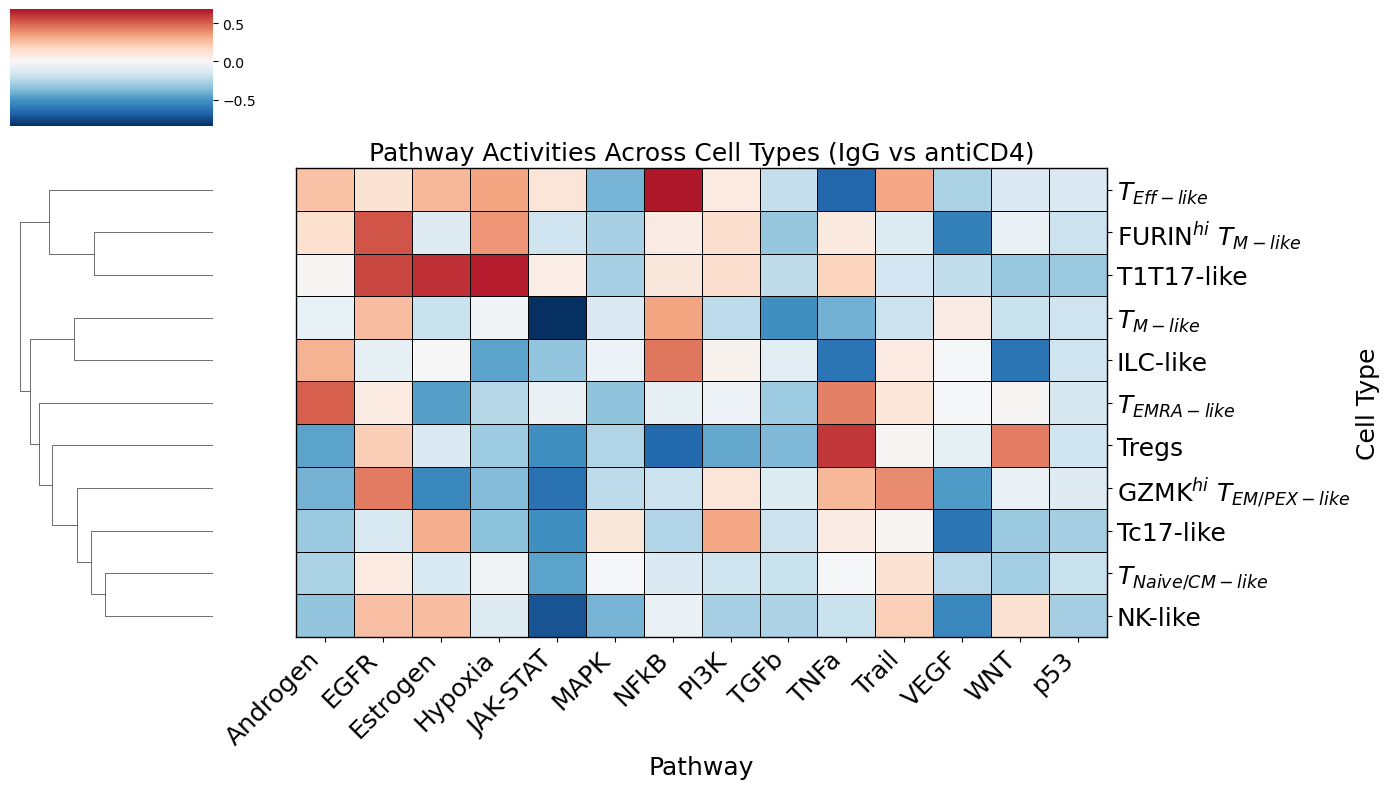

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def symmetric_log10_transform(x, constant=1):
    return np.sign(x) * np.log10(np.abs(x) + constant)

def plot_pathway_heatmap(pathway_results):
    combined_results = pd.DataFrame()
    for cell_type, result_df in pathway_results.items():
        df_flat = result_df.T
        df_flat['Pathway'] = df_flat.index 
        df_flat['Cell Type'] = cell_type
        combined_results = pd.concat([combined_results, df_flat], axis=0)
    
    combined_results = combined_results.pivot(index='Cell Type', columns='Pathway', values='scores')
    
    print("Pivoted Combined Results:\n", combined_results.head())
    
    transformed_results = combined_results.applymap(symmetric_log10_transform)
    
    print("Transformed Combined Results:\n", transformed_results.head())
    
    g = sns.clustermap(transformed_results, cmap='RdBu_r', center=0, annot=False, linewidths=0.5, linecolor='black', 
                       cbar_kws={"shrink": 0.75}, figsize=(14, 8), col_cluster=False)
    g.ax_heatmap.set_title('Pathway Activities Across Cell Types (IgG vs antiCD4)', fontsize=18)
    g.ax_heatmap.set_xlabel('Pathway', fontsize=18)
    g.ax_heatmap.set_ylabel('Cell Type', fontsize=18)
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=18)
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=18)
    
    for spine in g.ax_heatmap.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.tight_layout()
    #plt.savefig('/Users/joshuadavidbromley/Desktop/PseudoBulk_Progeny_DE_IgGvsaCD4.png',
                #bbox_inches="tight",dpi=1000,transparent=True)
    plt.show()

plot_pathway_heatmap(pathway_results)


Pivoted Combined Results:
 Pathway                    Androgen      EGFR  Estrogen   Hypoxia   JAK-STAT  \
Cell Type                                                                      
$T_{EMRA-like}$           -0.514205 -0.757269 -1.590206  0.344756  -1.995364   
$T_{Eff-like}$             0.614011 -0.516150  1.477849  0.358025  -2.432819   
$T_{M-like}$               0.669688  0.892215 -0.670230  0.625412 -26.260273   
$T_{Naive/CM-like}$       -0.633484 -0.586028 -0.119124  0.319283  -8.002267   
FURIN$^{hi}$ $T_{M-like}$ -0.870009  3.047376 -0.245962  1.119128  -4.310024   

Pathway                        MAPK      NFkB      PI3K      TGFb      TNFa  \
Cell Type                                                                     
$T_{EMRA-like}$           -1.282005 -0.111764 -0.241179  0.658686  0.634271   
$T_{Eff-like}$            -1.195462  4.538652 -0.056359  0.331119 -4.118273   
$T_{M-like}$              -1.768282  0.322586 -0.739266 -0.481755 -0.350583   
$T_{Naive/CM-like

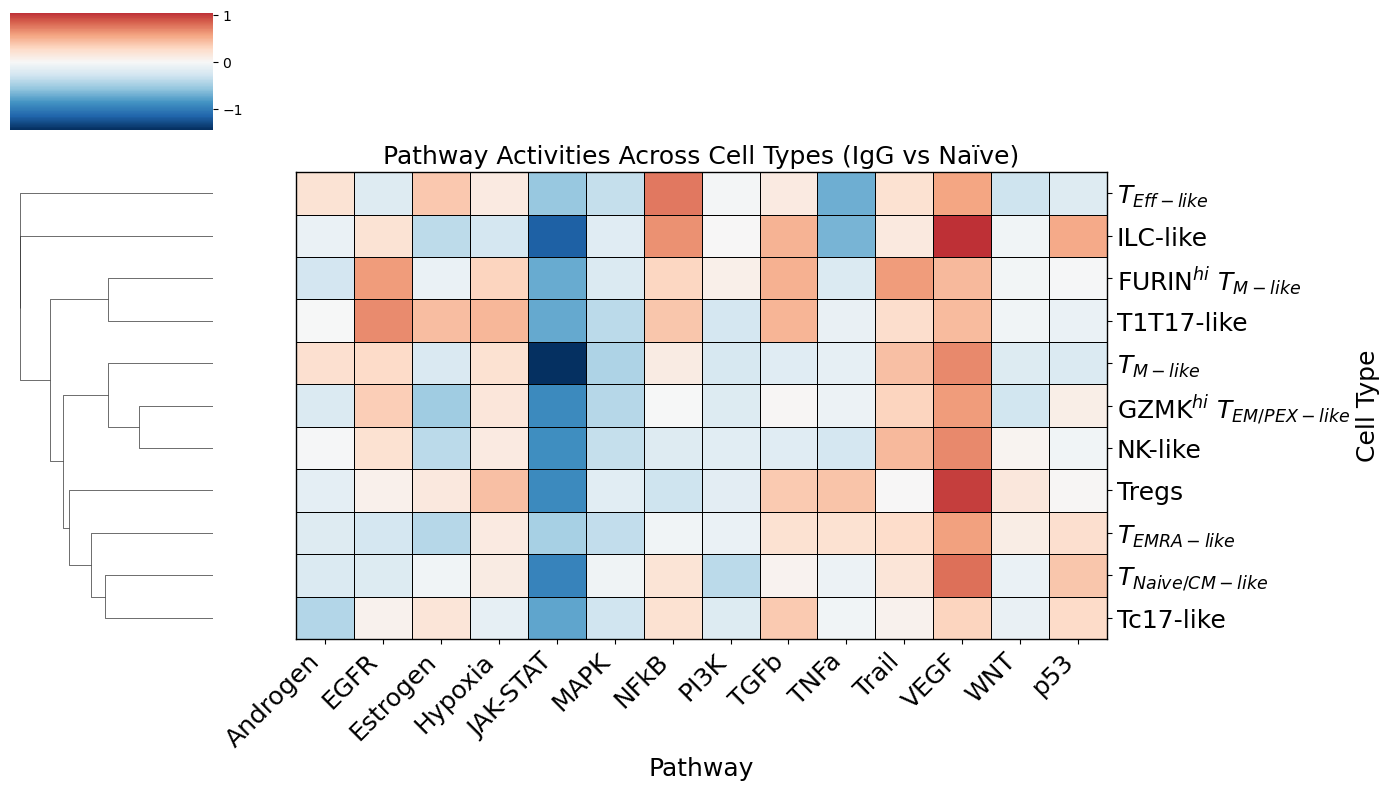

In [46]:
def symmetric_log10_transform(x, constant=1):
    return np.sign(x) * np.log10(np.abs(x) + constant)

def plot_pathway_heatmap(pathway_results):
    combined_results = pd.DataFrame()
    for cell_type, result_df in pathway_results.items():
        df_flat = result_df.T
        df_flat['Pathway'] = df_flat.index 
        df_flat['Cell Type'] = cell_type
        combined_results = pd.concat([combined_results, df_flat], axis=0)
    
    combined_results = combined_results.pivot(index='Cell Type', columns='Pathway', values='scores')
    
    print("Pivoted Combined Results:\n", combined_results.head())
    
    transformed_results = combined_results.applymap(symmetric_log10_transform)
    
    print("Transformed Combined Results:\n", transformed_results.head())
    
    g = sns.clustermap(transformed_results, cmap='RdBu_r', center=0, annot=False, linewidths=0.5, linecolor='black', 
                       cbar_kws={"shrink": 0.75}, figsize=(14, 8), col_cluster=False)
    g.ax_heatmap.set_title('Pathway Activities Across Cell Types (IgG vs Naïve)', fontsize=18)
    g.ax_heatmap.set_xlabel('Pathway', fontsize=18)
    g.ax_heatmap.set_ylabel('Cell Type', fontsize=18)
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=18)
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=18)
    
    for spine in g.ax_heatmap.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.tight_layout()
    #plt.savefig('/Users/joshuadavidbromley/Desktop/PseudoBulk_Progeny_DE_IgGvsNaive.png',
               # bbox_inches="tight",dpi=1000,transparent=True)
    plt.show()

plot_pathway_heatmap(pathway_results)